# Лабораторная работа 2

## Построение скелета бинарного изображения

Разработать программу построения скелета бинарного изображения на основе преобразований утоньшения.

Содержание отчета:
- Исходные изображения
- Код программы (для Jupyter Notebook)
- Результат работы программы
- Срок: 15.03.2025

In [ ]:
%pylab inline
import skimage.io
from matplotlib.pyplot import imread
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from numpy import invert
from scipy.ndimage import binary_erosion, binary_dilation

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def print_images(imgs, *, n_cols=None, fig_dim=None):
    if isinstance(imgs, np.ndarray):
        imgs = [imgs]
    num_imgs = len(imgs)
    if num_imgs == 1:
        n_rows, n_cols = 1, 1
        fig_dim = fig_dim or 5
    else:
        n_cols = n_cols or min(num_imgs, 3)
        n_rows = ceil(num_imgs / n_cols)
        fig_dim = fig_dim or 15
    figsize = (fig_dim, fig_dim / n_cols * n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.atleast_1d(axes).flatten()
    for ax, img in zip(axes, imgs):
        ax.imshow(img, cmap='gray' if img.ndim == 2 else None, interpolation='none')
        ax.axis('off')
    for ax in axes[num_imgs:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
img = (imread('binary.png'))
img.shape

(1016, 1024, 4)

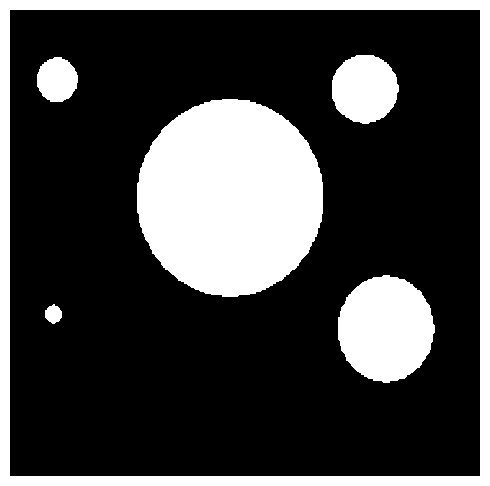

In [ ]:
from skimage.color import rgb2gray

img_rgb = img[:, :, :3]
img_gray = rgb2gray(img_rgb)
threshold = 0.5
img_binary = img_gray > threshold
print_images(img_binary)

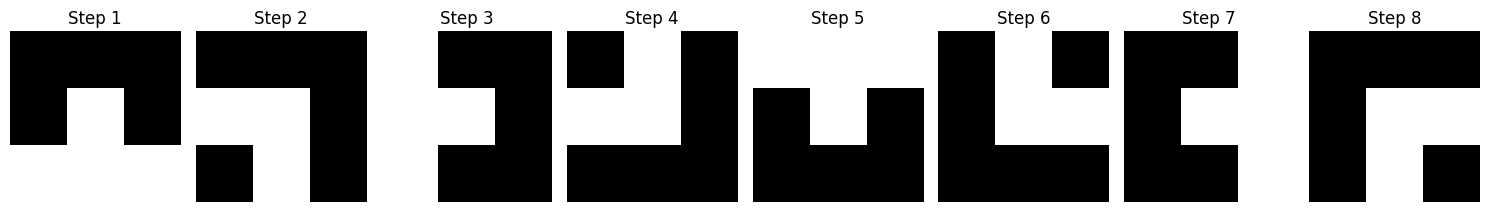

In [ ]:
c = np.array([1] * 3 + [0] * 5, dtype=bool)
perm = [0, 1, 2, 7, 8, 3, 6, 5, 4]
struct_miss = []
for i in range(8):
    rolled = np.roll(c, i)
    extended = np.concatenate((rolled, [False]))
    permuted = extended[perm]
    struct_miss.append(permuted.reshape(3, 3))
struct_miss = np.array(struct_miss)
struct_hit = np.roll(struct_miss, 4, axis=0)
struct_hit[:, 1, 1] = 1
struct_hit[1::2, ::2, ::2] = 0
struct_hit = struct_hit.astype(bool)

fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(struct_hit[i], cmap='gray', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f"Step {i + 1}")

plt.tight_layout()
plt.show()


In [ ]:
def hit_and_miss(img, hit, miss):
    """Perform hit-and-miss transform."""
    img_hit = binary_erosion(img, hit)
    img_miss = binary_erosion(invert(img), miss)
    return img * invert(img_hit * img_miss)

def thin_step(img, struct_hit, struct_miss):
    """Perform a thinning step using hit-and-miss transform."""
    for hit, miss in zip(struct_hit, struct_miss):
        img = hit_and_miss(img, hit, miss)
    return img

def skeletonize(img, struct_hit, struct_miss):
    """Perform skeletonization by iteratively applying thinning steps."""
    prev_img = np.zeros_like(img)
    while not np.array_equal(img, prev_img):
        prev_img = img.copy()
        img = thin_step(img, struct_hit, struct_miss)
    return img

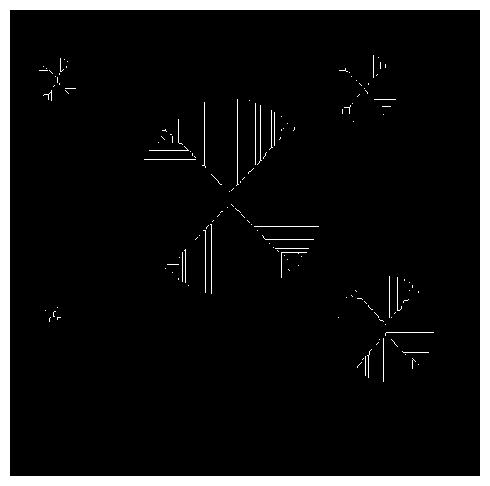

In [ ]:
skeleton = skeletonize(img_binary, struct_hit, struct_miss)
print_images(skeleton)
imsave('skeleton-thin.png', skeleton)